In [9]:
import os
from scipy.io import wavfile
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy
import pandas as pd
import stats
from scipy import stats


In [10]:
dire_fd = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\forward"
dire_bd = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\backward"
dire_lt = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\left"
dire_rt = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\right"
dire_unk = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\_unknown_"
dire_sil = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\_silence_"
dire_stp = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\stop"

# **2**

2.1

In [11]:
dicio = {
    "forward": [os.path.join(dire_fd, f) for f in os.listdir(dire_fd)],
    "backward": [os.path.join(dire_bd, f) for f in os.listdir(dire_bd)],
    "left": [os.path.join(dire_lt, f) for f in os.listdir(dire_lt)],
    "right": [os.path.join(dire_rt, f) for f in os.listdir(dire_rt)],
    "unknown": [os.path.join(dire_unk, f) for f in os.listdir(dire_unk)],
    "silence": [os.path.join(dire_sil, f) for f in os.listdir(dire_sil)],
    "stop": [os.path.join(dire_stp, f) for f in os.listdir(dire_stp)],
}

2.2



In [12]:
print("Forward: ", len(dicio["forward"]),
      "\nBackward: ", len(dicio["backward"]),
      "\nRight: ", len(dicio["right"]),
      "\nLeft: ", len(dicio["left"]),
      "\nUnknown: ", len(dicio["unknown"]),
      "\nSilence: ", len(dicio["silence"]),
      "\nStop: ", len(dicio["stop"]))


Forward:  1557 
Backward:  1664 
Right:  3778 
Left:  3801 
Unknown:  635 
Silence:  408 
Stop:  3872


2.3

In [13]:
def load_sounds(file_paths):
    sounds = []  
    all_data = []  

    for file_path in file_paths:
        sample_rate, data = wavfile.read(file_path)
        
        max_possible_value = np.iinfo(data.dtype).max if np.issubdtype(data.dtype, np.integer) else 1.0

        normalized_data = data / max_possible_value
        
        all_data.append(normalized_data)
        
        sounds.append((sample_rate, normalized_data))
    
    all_data_concatenated = np.concatenate(all_data)  
    global_min = np.min(all_data_concatenated) 
    global_max = np.max(all_data_concatenated)  


    normalized_sounds = []
    for sample_rate, data in sounds:
        normalized_data = 2 * (data - global_min) / (global_max - global_min) - 1
        normalized_sounds.append((sample_rate, normalized_data))
    

    return normalized_sounds


sounds_fd = load_sounds(dicio["forward"])
sounds_bd = load_sounds(dicio["backward"])
sounds_lt = load_sounds(dicio["left"])
sounds_rt = load_sounds(dicio["right"])
sounds_stp = load_sounds(dicio["stop"])
sounds_unk = load_sounds(dicio["unknown"])
sounds_sil = load_sounds(dicio["silence"])



In [14]:
info = np.iinfo(np.int16)
info

iinfo(min=-32768, max=32767, dtype=int16)

**2.4**

- Com valor absoluto

In [15]:
def envelope(signal, window_size):
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd number.")

    half_window = window_size // 2

    padded_signal = np.pad(np.abs(signal), (half_window, half_window), mode='constant')

    envelope_signal = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
    
    return envelope_signal


In [16]:
# len(envelope(sounds_fd[0][1],99)) == len(sounds_fd[0][1])


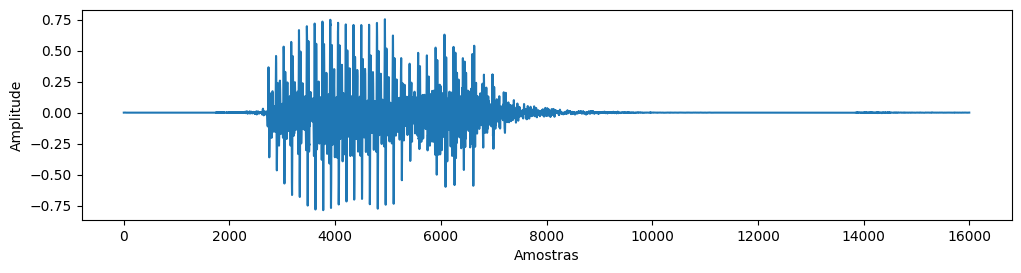

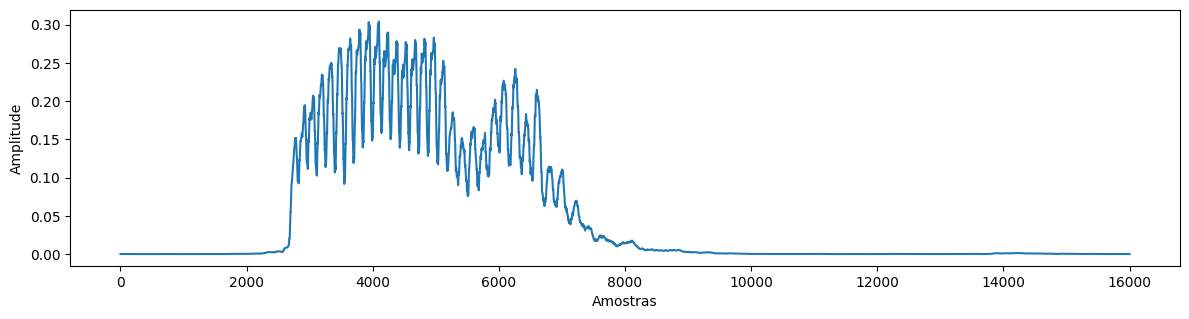

In [17]:
x = range(len(sounds_fd[1][1]))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, sounds_fd[1][1])
plt.xlabel("Amostras")
plt.ylabel("Amplitude")

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)
plt.plot(x, envelope(sounds_fd[1][1],99))
plt.xlabel("Amostras")
plt.ylabel("Amplitude")

plt.tight_layout()  
plt.show() 

**2.5**

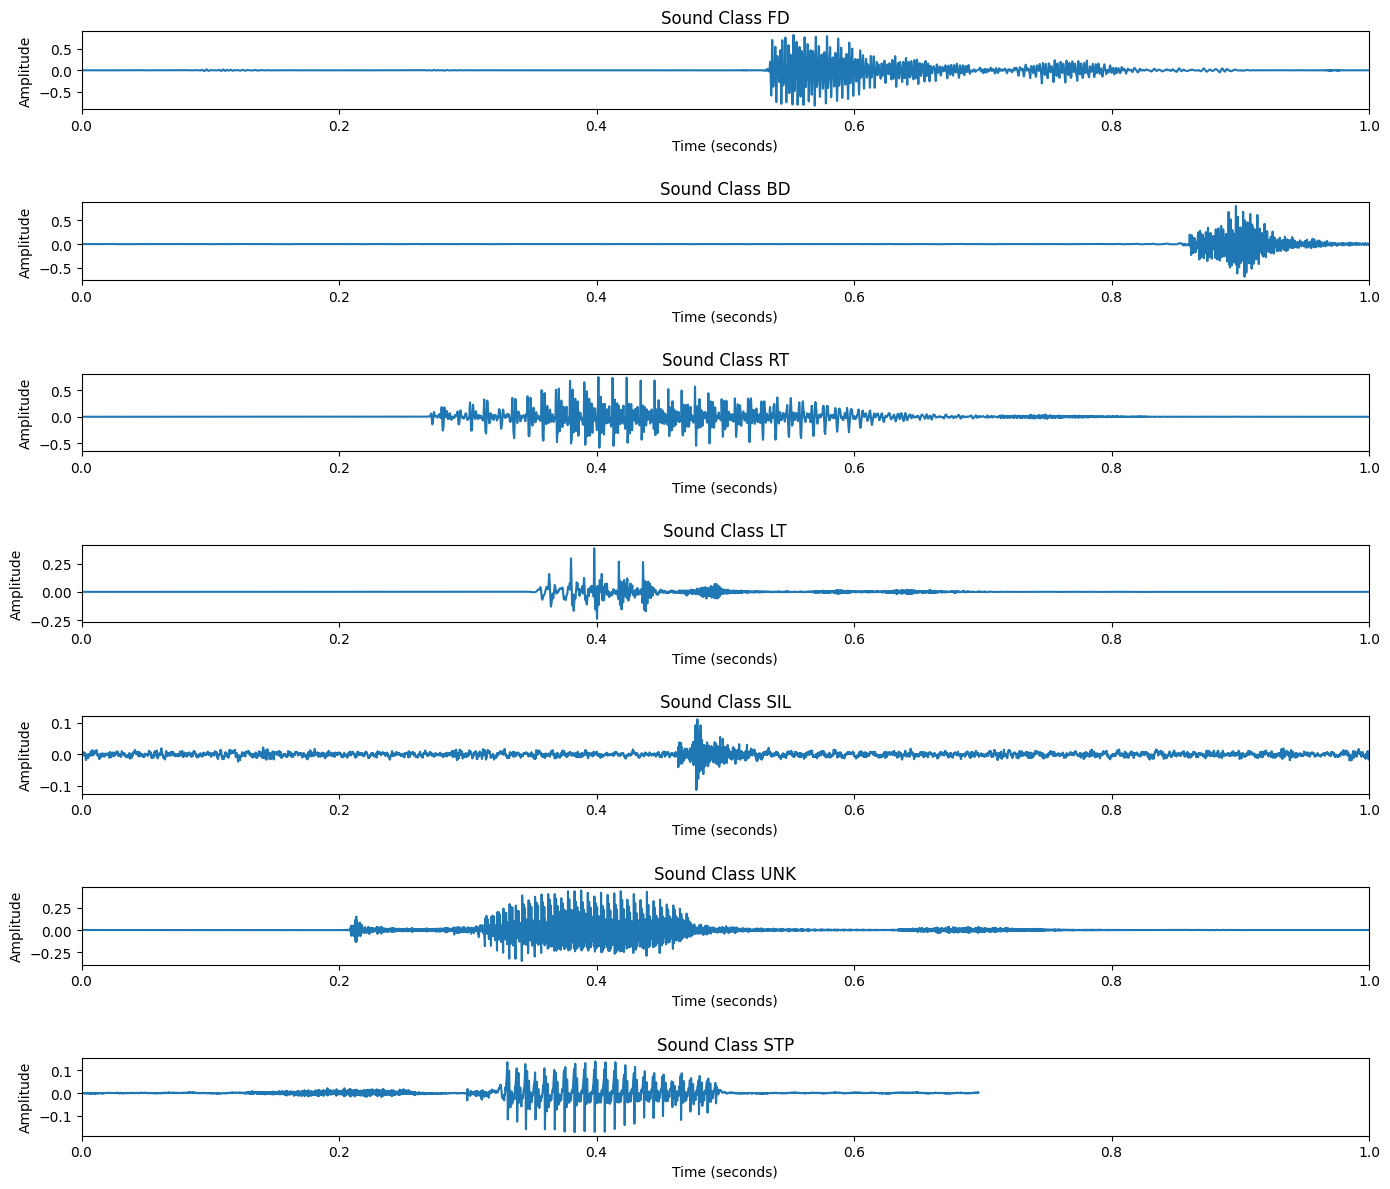

In [18]:
def plot_random_sounds(sounds, titles, sample_rate=16000):
    """
    Selects one random sample from each sound class and generates a figure with subplots displaying 
    the sound signals over time, with the x-axis forced to show time from 0 to 1 second.
    
    Parameters:
    - sounds (list of lists): A list where each element is a list of sound data arrays for each class.
    - titles (list of str): A list of titles for each class to be shown in the plot.
    - sample_rate (int, optional): The sample rate (in Hz) used to calculate the time axis. Default is 16000 Hz.

    """
    
    ss = []  
    
    for elem in sounds:
        selected_sound = rd.choice(elem)[1]  
        ss.append(np.asarray(selected_sound))
    
    plt.figure(figsize=(14, 12))

    num_classes = len(ss)

    for i, sound in enumerate(ss):
        if sound.ndim == 0:
            raise ValueError(f"The selected sound from class {i + 1} is not valid (empty or 0D).")
        
        sound_length = len(sound)
        time = np.linspace(0, min(1, sound_length / sample_rate), num=sound_length)  

        plt.subplot(num_classes, 1, i + 1)
        plt.plot(time, sound)
        plt.title(titles[i]) 
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.xlim(0, 1)  

    plt.tight_layout()  
    plt.subplots_adjust(hspace=1.2)  
    plt.show()



sounds = [sounds_fd, sounds_bd, sounds_rt, sounds_lt, sounds_sil, sounds_unk, sounds_stp]
titles = [
    "Sound Class FD", "Sound Class BD", "Sound Class RT", "Sound Class LT",
    "Sound Class SIL", "Sound Class UNK", "Sound Class STP"
]
plot_random_sounds(sounds, titles)


**3**

**3.1**

In [19]:
def duration(som):
    
    dura = []
    for i in range(len(som)):
        tempo = len(som[i][1])/som[i][0]
        dura.append(tempo)

    return dura




In [20]:
duracao_fd = duration(sounds_fd)
duracao_bd = duration(sounds_bd)
duracao_lt = duration(sounds_lt)
duracao_rt = duration(sounds_rt)
duracao_stp = duration(sounds_stp)
duracao_unk = duration(sounds_unk)
duracao_sil = duration(sounds_sil)

**3.2**
- Create a function that returns an array with the average amplitude of the
envelope of each sound of a given class.

In [21]:
def avg_amplitude(som,window_size=99):
    avg = []  
    
    for i in range(len(som)):
        sound_data = som[i][1]
        
        envelope_signal = envelope(sound_data, window_size)
        
        avg_amplitude = np.mean(np.abs(envelope_signal))  
        
        avg.append(avg_amplitude)
    
    return avg


In [22]:
med_fd = avg_amplitude(sounds_fd)
med_bd = avg_amplitude(sounds_bd)
med_lt = avg_amplitude(sounds_lt)
med_rt = avg_amplitude(sounds_rt)
med_stp = avg_amplitude(sounds_stp)
med_unk = avg_amplitude(sounds_unk)
med_sil = avg_amplitude(sounds_sil)

**UNIVARIATE APPROACH**

**3.3**

In [23]:
def outlier_detect(values, method, threshold):
    if method not in ['iqr', 'zscore']:
        raise ValueError("Method must be 'iqr' or 'zscore'.")
    
    outlier_indices = []  

    if method == 'iqr':
        Q1 = np.percentile(values, 25) 
        Q3 = np.percentile(values, 75)
        IQR = Q3 - Q1 

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outlier_indices = np.where((values < lower_bound) | (values > upper_bound))[0]

    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(values))  
        outlier_indices = np.where(z_scores > threshold)[0]

    no = len(outlier_indices) 
    nr = len(values)  
    density = (no / nr) * 100  

    return density, outlier_indices.tolist()


sound_data = sounds_fd[0][1]  
density, outlier_indices = outlier_detect(sound_data, method='iqr', threshold=3.5)

print("Outlier Density:", density)
print("Outlier Indices:", outlier_indices)


Outlier Density: 22.8125
Outlier Indices: [6561, 6567, 6568, 6573, 6964, 6965, 7170, 7176, 7237, 7250, 7360, 7444, 7445, 7446, 7451, 7452, 7453, 7506, 7507, 7508, 7514, 7515, 7516, 7517, 7522, 7523, 7524, 7546, 7547, 7548, 7597, 7633, 7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7673, 7674, 7675, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7738, 7739, 7740, 7741, 7744, 7745, 7746, 7747, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7811, 7812, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7832, 7833, 7834, 7835, 7836, 7839, 7840, 7841, 7842, 7843, 784

- **3.4**

- **3.4.1**

- **3.4.2**

- **3.4.3**

O m√©todo do z-score e o m√©todo do IQR apresentam diferen√ßas significativas nos resultados, dependendo dos thresholds utilizados.
Z-score:

Threshold 3: Identifica valores moderadamente afastados da m√©dia como outliers.
Threshold 3.5: Mais seletivo, exclui valores apenas moderadamente distantes.
Threshold 4: Muito rigoroso, captura apenas os valores mais extremos.

IQR:

Threshold 3: Muito conservador, identifica apenas os valores muito afastados dos quartis.

A escolha do m√©todo e do threshold deve considerar a natureza dos dados e os objetivos da an√°lise. Thresholds menores no z-score s√£o √∫teis para identificar mais outliers, enquanto thresholds maiores evitam a detec√ß√£o de valores apenas moderadamente afastados. O IQR com threshold alto (3) √© indicado quando se prioriza a identifica√ß√£o de outliers extremos.

# **MULTIVARIATE APPROCAH**


- **3.5**

- **3.6**

- **3.7**

Os resultados mostram que o K-means identifica menos outliers √† medida que k aumenta, enquanto IQR e Z-Score detectam menos outliers com thresholds (k) maiores. Isso ocorre porque:

K-means: Com 
ùëò
k maior, os clusters ficam mais especializados, incorporando pontos que poderiam ser considerados outliers em 
ùëò
k menores.

IQR e Z-Score: Thresholds mais altos aumentam a toler√¢ncia a desvios, reduzindo a identifica√ß√£o de outliers.

A escolha do m√©todo depende do objetivo da an√°lise: K-means √© √∫til para contextos de agrupamento, enquanto IQR e Z-Score s√£o mais robustos para detec√ß√£o estat√≠stica de anomalias. Visualiza√ß√µes podem complementar a interpreta√ß√£o.

**4**


- **4.1**

In [24]:
def get_first_200_songs(sounds):
    return sounds[:200]

first_200_fd = get_first_200_songs(sounds_fd)
first_200_bd = get_first_200_songs(sounds_bd)
first_200_rt = get_first_200_songs(sounds_rt)
first_200_lt = get_first_200_songs(sounds_lt)
first_200_stp = get_first_200_songs(sounds_stp)
first_200_sil = get_first_200_songs(sounds_sil)
first_200_unk = get_first_200_songs(sounds_unk)

print(len(first_200_fd), len(first_200_bd), len(first_200_rt), len(first_200_lt), len(first_200_stp), len(first_200_sil), len(first_200_unk))
print(first_200_bd[0])


200 200 200 200 200 200 200
(16000, array([-0.06575113, -0.07090867, -0.07530327, ..., -0.06996262,
       -0.07304494, -0.07042039]))


In [25]:
def env_200(sound):
    fator = 99
    sound_1 = []
    for i in range(len(sound)):
        env = envelope(sound[i][1],fator)
        down_env = env[::100]
        sound_1.append(down_env)
    return sound_1

env_fd = env_200(first_200_fd)
env_bd = env_200(first_200_bd)
env_rt = env_200(first_200_rt)
env_lt = env_200(first_200_lt)
env_sil = env_200(first_200_sil)
env_unk = env_200(first_200_unk)
env_stp = env_200(first_200_stp)
print(len(env_fd[1]))


160


In [26]:
data = {
    'forward': env_fd,
    'backward': env_bd,
    'left': env_lt,
    'right': env_rt,
    'stop': env_stp,
    'silence': env_sil,
    'unknown': env_unk
}

df_sec = pd.DataFrame(data)

df_no_outliers = df_sec.copy() 

df_sec

forward  \
0    [0.0001118994939091067, 0.00023597537902870854...   
1    [0.0001525902189669637, 0.0001727814499615821,...   
2    [0.0002937747043949827, 0.0004591578407096817,...   
3    [0.00016276290023142792, 0.0002840644177334485...   
4    [0.0003464876891290246, 0.0003620549740943411,...   
..                                                 ...   
195  [0.00028699291688533975, 0.0006931295097923594...   
196  [1.5413153431006432e-05, 2.5123440092540488e-0...   
197  [1.4488364225146046e-05, 2.019123099461843e-05...   
198  [1.1097470470324632e-05, 1.5259021896696368e-0...   
199  [2.065362559754862e-05, 3.406306908252423e-05,...   

                                              backward  \
0    [0.03756586233125487, 0.07015158065741725, 0.0...   
1    [0.00020006273153446352, 0.0002911544683117116...   
2    [0.00011991433369323003, 0.0002273440131073448...   
3    [0.0002339716690826777, 0.0002846809438706889,...   
4    [6.566003361608739e-05, 0.00010681315327687459...   
..                                                 ...   
195  [0.001974424954511933, 0.0039520866712443705, ...   
196  [0.0004472897125678079, 0.000957619222668433, ...   
197  [0.00025123440092540483, 0.000500773354973399,...   
198  [0.0005024688018508131, 0.0006505892063227816,...   
199  [0.00028514333847361905, 0.0005584185488053631...   

                                                  left  \
0    [0.00010943338936014568, 0.0002230283301466630...   
1    [0.0008313854960684925, 0.0009998512630693952,...   
2    [0.0003415554800311026, 0.00046532310208208423...   
3    [0.0007339743663845308, 0.0015615065740952707,...   
4    [0.0003187440129532131, 0.0007606391218201676,...   
..                                                 ...   
195  [0.0005092505893604525, 0.001121923438242968, ...   
196  [0.00027990286630707686, 0.0009613183794918713...   
197  [0.002552726471243288, 0.00198074434741864, 0....   
198  [3.6991568234415446e-05, 7.9069477101063e-05, ...   
199  [6.196087679264588e-05, 9.972310269861161e-05,...   

                                                 right  \
0    [0.0005154158507328574, 0.0011012698126454117,...   
1    [0.00020684451904410633, 0.0002526215847341954...   
2    [6.041956144954522e-05, 0.00010527183793377395...   
3    [0.0028776357455689073, 0.005865783801238131, ...   
4    [0.00417079931843034, 0.009847926121672953, 0....   
..                                                 ...   
195  [0.00026387318673883015, 0.0005312913987667919...   
196  [0.0005095588524290727, 0.0007849919042411599,...   
197  [0.0005940229332309878, 0.0008901096106406283,...   
198  [5.3637773939902395e-05, 0.0001086627316885953...   
199  [5.9186509175064706e-05, 0.0001182188868158193...   

                                                  stop  \
0    [0.002376091732923954, 0.005183597630381793, 0...   
1    [0.0004395831358523035, 0.000603424956823903, ...   
2    [0.00048428128080222217, 0.0005926357494221974...   
3    [9.89524450270613e-05, 0.0001274667788744232, ...   
4    [8.261450239019447e-05, 0.00014010556468784847...   
..                                                 ...   
195  [7.552445181193153e-05, 0.00013733119707026734...   
196  [6.2269139861266e-05, 0.000122226306707881, 0....   
197  [4.130725119509725e-05, 9.109173677724803e-05,...   
198  [4.870556484198034e-05, 0.00010003136576723176...   
199  [0.0025758462013898047, 0.002801957162222667, ...   

                                               silence  \
0    [0.0001662246391346626, 0.00038445251732821545...   
1    [0.016667347661463865, 0.023908179614235015, 0...   
2    [4.3955118728351635e-05, 7.645714314017372e-05...   
3    [0.00036928490593604065, 0.0017000106482822864...   
4    [0.00010834008137268273, 0.0002624925400115317...   
..                                                 ...   
195  [0.0005299377694572544, 0.0010400647811777853,...   
196  [0.00019067854321592925, 0.0003519504929164046...   
197  [0.06646385403433701, 0.10428320963

- **4.2**

- **4.2.1**

- **4.3**

- **4.4**

- **4.5**



O trabalho foi dividido e, por isso, a partir deste ponto vamos redefinar vari√°veis que n√£o s√£o compat√≠veis entre c√≥digos.




In [27]:
import os
from scipy.io import wavfile


 #SUBSTITUIR PELOS RESPETIVOS DIRETORIOS
dire_fd = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\forward"
dire_bd = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\backward"
dire_lt = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\left"
dire_rt = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\right"
dire_unk = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\_unknown_"
dire_sil = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\_silence_"
dire_stp = "C:\\Users\\Miguel Ant√≥nio\\Desktop\\3\\EA\\PR√ÅTICAS\\MODULOB\\dataset\\stop"


dicio = {"forward":dire_fd,"backward":dire_bd,"right":dire_rt,"left":dire_lt,"unknown":dire_unk,"silence":dire_sil,"stop":dire_stp}

def load_songs_by_class(dicio):
    
    forward_songs = []
    backward_songs = []
    right_songs = []
    left_songs = []
    unknown_songs = []
    silence_songs = []
    stop_songs = []
    
    # Map class names to lists for easier assignment
    lists_map = {
        "forward": forward_songs,
        "backward": backward_songs,
        "right": right_songs,
        "left": left_songs,
        "unknown": unknown_songs,
        "silence": silence_songs,
        "stop": stop_songs
    }
    
    for class_name, directory in dicio.items():
        songs = lists_map[class_name]
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)
            if file_path.endswith(".wav"):  
                fs, data = wavfile.read(file_path)
                songs.append((fs, data))  
    
    return forward_songs, backward_songs, right_songs, left_songs, unknown_songs, silence_songs, stop_songs

forward_songs, backward_songs, right_songs, left_songs, unknown_songs, silence_songs, stop_songs = load_songs_by_class(dicio)

# Example access
print("Forward Songs:", forward_songs)
print("Backward Songs:", backward_songs)

Forward Songs: [(16000, array([   0,   -4,   -3, ..., 2615, 2393, 1874], dtype=int16)), (16000, array([ 1,  5,  9, ..., 12,  3,  9], dtype=int16)), (16000, array([ -1, -12, -19, ...,  19,  11,   6], dtype=int16)), (16000, array([ 3, -6, -7, ..., 18, 16,  3], dtype=int16)), (16000, array([  0,  -8, -14, ..., -28, -29, -12], dtype=int16)), (16000, array([28, 33, 26, ...,  7, 27, 33], dtype=int16)), (16000, array([2, 8, 6, ..., 6, 3, 6], dtype=int16)), (16000, array([ 1,  2, -2, ...,  0,  0, -6], dtype=int16)), (16000, array([11, 14, 11, ..., 56, 62, 64], dtype=int16)), (16000, array([ 0,  7,  4, ..., -7, -9, -3], dtype=int16)), (16000, array([  4,   1,  -4, ...,  -4,  -7, -13], dtype=int16)), (16000, array([-2, -2, -2, ..., 91, 78, 68], dtype=int16)), (16000, array([  0,  -2,  -2, ..., 421, 488, 300], dtype=int16)), (16000, array([ 0,  1,  2, ..., -1,  0,  3], dtype=int16)), (16000, array([  0,   0,   0, ..., -15, -14, -13], dtype=int16)), (16000, array([ 2,  2,  2, ..., -4, -4, -4], dty

5

5.1
Estado da Arte na Classifica√ß√£o de Sons

A classifica√ß√£o de sons tornou-se uma √°rea de pesquisa e aplica√ß√£o cada vez mais importante, especialmente com o aumento das t√©cnicas de aprendizado de m√°quina e aprendizado profundo. O objetivo da classifica√ß√£o de sons √© categorizar automaticamente sinais de √°udio em classes predefinidas, que podem incluir g√™neros musicais, sons ambientais, fala e muito mais. A efic√°cia dos sistemas de classifica√ß√£o de sons depende em grande parte da escolha das caracter√≠sticas extra√≠das dos sinais de √°udio, uma vez que essas caracter√≠sticas encapsulam as caracter√≠sticas essenciais dos sons que est√£o a ser analisados.

Caracter√≠sticas Chave na Classifica√ß√£o de Sons

 Energia de Raiz M√©dia Quadrada (RMS): A energia RMS √© uma caracter√≠stica fundamental que quantifica a energia do sinal de √°udio. √â crucial para distinguir entre diferentes classes de som, pois reflete a intensidade e o volume do som. A inclus√£o tanto da m√©dia quanto do desvio padr√£o da energia RMS fornece informa√ß√µes sobre a variabilidade do volume ao longo do tempo.

 Caracter√≠sticas Espectrais: Caracter√≠sticas como o centr√≥ide espectral, largura de banda e roll-off s√£o essenciais para capturar as caracter√≠sticas de frequ√™ncia dos sons. O centr√≥ide espectral indica o "centro de massa" do espectro, enquanto a largura de banda mede a dispers√£o das frequ√™ncias. O roll-off espectral fornece informa√ß√µes sobre a frequ√™ncia abaixo da qual uma certa porcentagem da energia espectral total se encontra. Essas caracter√≠sticas ajudam a diferenciar entre v√°rios tipos de som, como fala e m√∫sica.

 Pitch e For√ßa do Pitch: O pitch √© uma caracter√≠stica cr√≠tica na classifica√ß√£o de sons, particularmente para sons musicais e fala. Ele fornece informa√ß√µes sobre a frequ√™ncia percebida do som, enquanto a for√ßa do pitch quantifica a proemin√™ncia do pitch. Essas caracter√≠sticas s√£o particularmente √∫teis para distinguir entre diferentes notas musicais ou comandos falados.

 Energia de Modula√ß√£o: As caracter√≠sticas de energia de modula√ß√£o (loudness e sharpness) em diferentes bandas de frequ√™ncia (1-2 Hz, 3-15 Hz e 20-150 Hz) capturam a din√¢mica temporal do som. Essas caracter√≠sticas s√£o importantes para entender os padr√µes r√≠tmicos e temporais em sinais de √°udio, que podem ser cruciais para classificar sons como m√∫sica ou fala.

 Taxa de Cruzamento de Zero (ZCR): A ZCR mede a taxa na qual o sinal de √°udio muda de positivo para negativo ou vice-versa. √â uma caracter√≠stica √∫til para distinguir entre sons com e sem voz, tornando-se particularmente relevante para a classifica√ß√£o de fala.

 Coeficientes Cepstrais em Mel (MFCCs): Os MFCCs s√£o amplamente utilizados em tarefas de classifica√ß√£o de √°udio devido √† sua efic√°cia em representar o envelope espectral dos sons. A m√©dia e o desvio padr√£o dos primeiros MFCCs capturam tanto as caracter√≠sticas m√©dias quanto a variabilidade do som, o que √© essencial para uma classifica√ß√£o robusta.

Justifica√ß√£o das Escolhas de Caracter√≠sticas

As caracter√≠sticas selecionadas para o seu sistema de classifica√ß√£o de sons est√£o bem alinhadas com o estado da arte na an√°lise de √°udio. Cada caracter√≠stica contribui de forma √∫nica para a tarefa de classifica√ß√£o:

- M√©dia e Desvio Padr√£o da RMS: Essas caracter√≠sticas fornecem uma compreens√£o b√°sica da intensidade e din√¢mica de energia do √°udio, que √© fundamental para distinguir entre diferentes classes de som.

- Caracter√≠sticas Espectrais (Centr√≥ide, Largura de Banda, Roll-off): Essas caracter√≠sticas s√£o cr√≠ticas para capturar a distribui√ß√£o de frequ√™ncia dos sons, permitindo que o sistema diferencie v√°rios tipos de √°udio com base em suas caracter√≠sticas espectrais.

- Pitch e For√ßa do Pitch: A inclus√£o dessas caracter√≠sticas melhora a capacidade do sistema de reconhecer padr√µes musicais e de fala, que muitas vezes s√£o definidos por suas caracter√≠sticas de pitch.

- Caracter√≠sticas de Energia de Modula√ß√£o: Essas caracter√≠sticas capturam a din√¢mica temporal dos sons, que s√£o essenciais para reconhecer padr√µes r√≠tmicos em m√∫sica e fala.

- Taxa de Cruzamento de Zero: Esta caracter√≠stica ajuda a distinguir entre segmentos com e sem voz, o que √© particularmente √∫til na classifica√ß√£o de fala.

- MFCCs: A inclus√£o dos MFCCs √© justificada pela sua efic√°cia comprovada em capturar o envelope espectral dos sinais de √°udio, tornando-os um elemento fundamental nas tarefas de classifica√ß√£o de som.

No geral, a combina√ß√£o dessas caracter√≠sticas fornece uma representa√ß√£o abrangente dos sinais de √°udio, permitindo que o sistema de classifica√ß√£o diferencie efetivamente entre v√°rias classes de som. Este conjunto de caracter√≠sticas √© esperado para resultar em alta precis√£o de classifica√ß√£o, aproveitando tanto t√©cnicas tradicionais de an√°lise de √°udio quanto abordagens modernas de Machine Learning .

FONTE: https://www.researchgate.net/publication/250008991_Features_for_Audio_Classification

5.2

In [28]:

import numpy as np
import librosa
from scipy.signal import butter, lfilter

# Helper function to apply bandpass filter
def bandpass_filter(y, sr, lowcut, highcut):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype="band")
    y_filtered = lfilter(b, a, y)
    return y_filtered

def extract_features(y, sr):
    y = np.asarray(y, dtype=float)
    features = {}
    
    # Root Mean Square (RMS) Energy
    rms = librosa.feature.rms(y=y)
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    
    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_std'] = np.std(spectral_centroid)
    
    # Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['bandwidth_mean'] = np.mean(bandwidth)
    features['bandwidth_std'] = np.std(bandwidth)

    # Spectral Roll-off Frequency
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_std'] = np.std(rolloff)
    
    # Pitch and Pitch Strength
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[pitches > 0]
    features['pitch_mean'] = np.mean(pitch_values) if len(pitch_values) > 0 else 0
    features['pitch_strength'] = np.mean(magnitudes[magnitudes > 0]) if len(magnitudes[magnitudes > 0]) > 0 else 0
    
    # Psychoacoustic Features: Loudness and Sharpness Modulation Energy
    for (low, high), label in zip([(1, 2), (3, 15), (20, 150)], ['1_2', '3_15', '20_150']):
        y_band = bandpass_filter(y, sr, low, high)
        rms_band = librosa.feature.rms(y=y_band)
        features[f'loudness_modulation_energy_{label}'] = np.mean(rms_band)
        centroid_band = librosa.feature.spectral_centroid(y=y_band, sr=sr)
        features[f'sharpness_modulation_energy_{label}'] = np.mean(centroid_band)
    
    # Additional Features to Make 26 Total
    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    
    # MFCCs (first 4 coefficients: mean and std for each)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=4)
    for i in range(4):
        features[f'mfcc_mean_{i+1}'] = np.mean(mfccs[i])
        features[f'mfcc_std_{i+1}'] = np.std(mfccs[i])
    
    return features

# Example usage
sr, y = forward_songs[0] 
features = extract_features(y, sr)
print(f"Extracted features: {features}")
print(f"Feature vector length: {len(features)}")

Extracted features: {'rms_mean': np.float32(508.0406), 'rms_std': np.float32(729.4867), 'spectral_centroid_mean': np.float64(1988.553630181116), 'spectral_centroid_std': np.float64(825.6755117082853), 'bandwidth_mean': np.float64(1526.3734543704686), 'bandwidth_std': np.float64(508.9563515995741), 'rolloff_mean': np.float64(3437.127976190476), 'rolloff_std': np.float64(1588.7700049174418), 'pitch_mean': np.float64(1635.9027912789836), 'pitch_strength': np.float64(17809.996816881732), 'loudness_modulation_energy_1_2': np.float32(1.0527704), 'sharpness_modulation_energy_1_2': np.float64(622.1569123077086), 'loudness_modulation_energy_3_15': np.float32(12.2767), 'sharpness_modulation_energy_3_15': np.float64(737.4656141333024), 'loudness_modulation_energy_20_150': np.float32(123.50839), 'sharpness_modulation_energy_20_150': np.float64(804.6564473391838), 'zcr_mean': np.float64(0.18717447916666666), 'zcr_std': np.float64(0.101037575100965), 'mfcc_mean_1': np.float64(540.889482240045), 'mfc

5.3

In [29]:
import pandas as pd

def extract_features_for_all_sounds_limited(dicio, max_samples_per_class=15):
    # Load all sounds by class
    forward_songs, backward_songs, right_songs, left_songs, unknown_songs, silence_songs, stop_songs = load_songs_by_class(dicio)
    
    # Map each class to its list of songs and assign class labels
    class_map = {
        "forward": forward_songs,
        "backward": backward_songs,
        "right": right_songs,
        "left": left_songs,
        "unknown": unknown_songs,
        "silence": silence_songs,
        "stop": stop_songs
    }
    
    # Prepare lists to hold data
    feature_data = []
    class_labels = []

    # Extract features for each class and store in lists, limiting to max_samples_per_class
    for class_label, songs in class_map.items():
        for i, (sr, y) in enumerate(songs):
            if i >= max_samples_per_class:  # Limit to first N samples per class
                break
            features = extract_features(y, sr)  # Extract 26 features
            feature_data.append(features)
            class_labels.append(class_label)
    
    # Define column names for the 26 features
    feature_columns = [
        "rms_mean", "rms_std",
        "spectral_centroid_mean", "spectral_centroid_std",
        "bandwidth_mean", "bandwidth_std",
        "rolloff_mean", "rolloff_std",
        "pitch_mean", "pitch_strength",
        "loudness_modulation_energy_1_2", "sharpness_modulation_energy_1_2",
        "loudness_modulation_energy_3_15", "sharpness_modulation_energy_3_15",
        "loudness_modulation_energy_20_150", "sharpness_modulation_energy_20_150",
        "zcr_mean", "zcr_std",
        "mfcc_mean_1", "mfcc_std_1",
        "mfcc_mean_2", "mfcc_std_2",
        "mfcc_mean_3", "mfcc_std_3",
        "mfcc_mean_4", "mfcc_std_4"
    ]

    # Create DataFrame with features and labels
    features_df = pd.DataFrame(feature_data, columns=feature_columns)
    features_df['Class'] = class_labels
    
    return features_df

# Usage example
# Assuming `dicio` is defined and points to directories for each class
features_df = extract_features_for_all_sounds_limited(dicio, max_samples_per_class=15)
print(features_df.head())

      rms_mean      rms_std  spectral_centroid_mean  spectral_centroid_std  \
0   508.040588   729.486694             1988.553630             825.675512   
1  2354.223633  3275.735107             1670.776935             831.342557   
2  2188.431885  2982.490967             1879.022401             943.900959   
3  2230.978516  3065.936035             1940.371732            1148.999606   
4  2484.153076  3549.256592             2238.301179            1414.344502   

   bandwidth_mean  bandwidth_std  rolloff_mean  rolloff_std   pitch_mean  \
0     1526.373454     508.956352   3437.127976  1588.770005  1635.902791   
1     1610.747326     676.324156   3305.419922  2025.155520   924.569587   
2     1736.322571     770.897104   3944.335938  2254.563472  1065.480592   
3     1698.590613     771.002071   3794.677734  2308.344419   945.127128   
4     1773.454161     714.558061   4196.044922  2280.428268  1023.458097   

   pitch_strength  ...   zcr_std  mfcc_mean_1  mfcc_std_1  mfcc_mean_2  \


In [30]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def evaluate_feature_discriminative_power(features_df, feature_name, class_column='Class', alpha=0.01):

    result = {"Feature": feature_name}
    class_labels = features_df[class_column]
    unique_classes = class_labels.unique()

    # Group the feature data by class
    grouped_data = [features_df[feature_name][class_labels == cls] for cls in unique_classes]
    
    # Step 1: Normality Test
    normality_results = [stats.shapiro(data) for data in grouped_data]
    all_normal = all(p_value > alpha for _, p_value in normality_results)
    result["Normality"] = "Normal" if all_normal else "Non-Normal"

    # Step 2: Select and Apply Test
    if all_normal:
        # Parametric test: One-Way ANOVA
        test_name = "ANOVA"
        stat, p_value = stats.f_oneway(*grouped_data)
    else:
        # Non-parametric test: Kruskal-Wallis H test
        test_name = "Kruskal-Wallis H test"
        stat, p_value = stats.kruskal(*grouped_data)

    result["Test Applied"] = test_name
    result["p-value"] = p_value
    result["Discriminative Power"] = "Significant" if p_value < alpha else "Not Significant"

    return result

# Example usage:
# Assuming `features_df` is the DataFrame with features and class labels
feature_result = evaluate_feature_discriminative_power(features_df, feature_name="loudness_modulation_energy_1_2")
print(feature_result)

{'Feature': 'loudness_modulation_energy_1_2', 'Normality': 'Non-Normal', 'Test Applied': 'Kruskal-Wallis H test', 'p-value': np.float64(0.5826236922780412), 'Discriminative Power': 'Not Significant'}


5.3.1

Primeiramente, utilizamos o teste de Shapiro-Wilk para verificar a normalidade dos dados. Este teste √© recomendado para conjuntos de dados moderados, pois √© altamente sens√≠vel e eficaz em detectar desvios da normalidade. A normalidade √© uma premissa importante para muitos testes estat√≠sticos, e sua verifica√ß√£o permite-nos escolher metodologias apropriadas para a an√°lise subsequente.

Como resultado da an√°lise de normalidade, se os dados n√£o atenderem aos pressupostos de uma distribui√ß√£o normal, optamos por utilizar o teste de Kruskal-Wallis para avaliar o poder de discrimina√ß√£o entre grupos. O Kruskal-Wallis √© um teste n√£o param√©trico, ideal para situa√ß√µes em que a normalidade n√£o √© garantida ou para dados com escalas ordinais. O teste verifica se as medianas dos grupos s√£o significativamente diferentes. Se os dados atenderem aos pressupostos de uma distribui√ß√£o normal, utilizamos o teste param√©trico ANOVA.

5.3.2

In [31]:
import pandas as pd
import scipy.stats as stats

def assess_normality_and_test(features_df, class_column='Class', alpha=0.01):
    """
    Assess normality of each feature and perform the appropriate statistical test.

    Parameters:
    - features_df (DataFrame): DataFrame containing features and class labels.
    - class_column (str): The column name containing class labels.
    - alpha (float): Significance level for normality and statistical tests.

    Returns:
    - results_df (DataFrame): A DataFrame with feature rankings and test results.
    """
    results = []
    class_labels = features_df[class_column]
    unique_classes = class_labels.unique()

    for feature_name in features_df.columns.drop(class_column):
        # Group feature data by class
        grouped_data = [features_df[feature_name][class_labels == cls] for cls in unique_classes]

        # Step 1: Normality Test (Anderson-Darling Test)
        normality_results = [stats.anderson(group, dist='norm') for group in grouped_data]
        all_normal = all(result.statistic < result.critical_values[2] for result in normality_results)  # 5% level

        # Step 2: Choose Statistical Test
        if all_normal:
            # Parametric test: One-Way ANOVA
            test_name = "ANOVA"
            stat, p_value = stats.f_oneway(*grouped_data)
        else:
            # Non-parametric test: Kruskal-Wallis H test
            test_name = "Kruskal-Wallis H test"
            stat, p_value = stats.kruskal(*grouped_data)

        # Store the result
        results.append({
            "Feature": feature_name,
            "Normality": "Normal" if all_normal else "Non-Normal",
            "Test Applied": test_name,
            "p-value": p_value
        })
    
    # Convert results to DataFrame and rank by p-value
    results_df = pd.DataFrame(results).sort_values(by="p-value", ascending=True)
    return results_df

# Example usage:
# Assuming `features_df` is the DataFrame with features and class labels
results_table = assess_normality_and_test(features_df)
print(results_table)

                               Feature   Normality           Test Applied  \
17                             zcr_std      Normal                  ANOVA   
5                        bandwidth_std  Non-Normal  Kruskal-Wallis H test   
21                          mfcc_std_2  Non-Normal  Kruskal-Wallis H test   
20                         mfcc_mean_2  Non-Normal  Kruskal-Wallis H test   
2               spectral_centroid_mean  Non-Normal  Kruskal-Wallis H test   
7                          rolloff_std  Non-Normal  Kruskal-Wallis H test   
3                spectral_centroid_std  Non-Normal  Kruskal-Wallis H test   
6                         rolloff_mean  Non-Normal  Kruskal-Wallis H test   
25                          mfcc_std_4  Non-Normal  Kruskal-Wallis H test   
23                          mfcc_std_3  Non-Normal  Kruskal-Wallis H test   
16                            zcr_mean  Non-Normal  Kruskal-Wallis H test   
19                          mfcc_std_1  Non-Normal  Kruskal-Wallis H test   

6

6.1

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume `features_df` is your DataFrame with extracted features and a 'Class' column
X = features_df.drop(columns=['Class']).values  # Drop the class column if it exists

# Step 1: Standardize the Feature Set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Fit the PCA Model
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the transformed features
pca_features_df = pd.DataFrame(X_pca)
print(pca_features_df)

           0         1         2         3         4         5         6   \
0   -0.376484  1.926783 -0.654628 -0.590222 -0.302771  1.311642 -0.321370   
1   -2.575669 -0.582042  1.216892  0.808614 -0.567672 -1.013605  0.012110   
2   -2.129286  0.138353  1.529883  1.507428 -0.598219 -0.683596 -0.006224   
3   -2.408606  0.281142  1.752275  2.173097 -0.658318 -0.510964  0.417200   
4   -1.896988  0.783044  2.731385  2.881930 -0.032400 -0.447346  1.105086   
..        ...       ...       ...       ...       ...       ...       ...   
100 -1.730718  1.267319 -1.016264  0.067298 -0.954519  1.215247  0.582098   
101 -2.389286  0.744827 -1.533689 -0.763827 -1.098048  1.073419  0.062381   
102 -0.128177  1.629175  0.951229  2.783500 -0.703095  0.262561  0.089788   
103 -0.378810  1.893309  1.253440  2.692947 -0.583339  0.430259  0.312817   
104  0.088996  2.151611  1.186635  2.393557 -0.165985  0.470696  0.052098   

           7         8         9   ...        16        17        18  \
0  

6.1.1


Cada componente principal √© uma combina√ß√£o linear de features do dataset e est√£o ranqueadas de forma descrescente em vari√¢ncia explicada.
Para explicar 75% da variabilidade do conjunto de features, deve-se somar a vari√¢ncia explicada por cada componente principal at√© que o valor acumulado atinja 75%. Isso indica quantos componentes principais s√£o necess√°rios para reter a maior parte da informa√ß√£o dos dados originais. A normaliza√ß√£o √© obrigat√≥ria porque a PCA √© sens√≠vel a escalas.
Cada componente principal √© uma combina√ß√£o linear de features do dataset est√£o ranqueado de forma descrescente em vari√¢ncia explicada.



6.1.2

In [33]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming features_df contains the features without the class labels
X = features_df.drop(columns=['Class'])
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Calculate cumulative variance explained
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_75 = (cumulative_variance >= 0.75).argmax() + 1

print(f"Number of components to explain 75% of the variance: {n_components_75}")

# Use only the required number of components to explain 75% variance
pca_75 = PCA(n_components=n_components_75)
X_pca_75 = pca_75.fit_transform(X_normalized) # <- TRANSFORMA√áAO


Number of components to explain 75% of the variance: 4


6.1.3

In [34]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def apply_pca_to_sound_75(sound, sr, expected_feature_order, scaler, pca_75):

    
    if expected_feature_order is None:
        if features_df is not None:
            expected_feature_order = features_df.drop(columns=['Class'], errors='ignore').columns
        else:
            raise ValueError("Either `expected_feature_order` or `features_df` must be provided.")
    # Extract features from the sound
    extracted_features = extract_features(sound, sr)

    # Convert the features dictionary into a DataFrame with the correct order
    features_list = [extracted_features[feature] for feature in expected_feature_order]
    new_data_df = pd.DataFrame([features_list], columns=expected_feature_order)

    # Apply scaling
    new_data_normalized = scaler.transform(new_data_df)
    
    # Apply precomputed PCA transformation
    new_data_pca = pca_75.transform(new_data_normalized)

    # Convert to DataFrame with appropriate column names
    transformed_data_df = pd.DataFrame(new_data_pca, columns=[f'PC{i+1}' for i in range(new_data_pca.shape[1])])

    return transformed_data_df

# Example usage:
# Assuming `scaler`, `expected_feature_order`, and `pca_75` are defined
sr, y = forward_songs[13]  # Example sound

expected_feature_order=None


transformed_new_data = apply_pca_to_sound_75(y, sr, expected_feature_order, scaler, pca_75)

print("PCA-transformed data for the new sound:")
print(transformed_new_data)


PCA-transformed data for the new sound:
       PC1       PC2       PC3       PC4
0 -3.50295  1.272233 -1.258319  0.773094


6.2

In [35]:
import numpy as np
import pandas as pd

def fisher_score(X, y):
    """
    Calculate Fisher Score for each feature.

    Parameters:
    - X (numpy array): Feature matrix (n_samples, n_features).
    - y (numpy array): Class labels (n_samples,).

    Returns:
    - fisher_scores (numpy array): Fisher scores for each feature.
    """
    unique_classes = np.unique(y)
    mean_total = np.mean(X, axis=0)
    fisher_scores = []

    for i in range(X.shape[1]):
        numerator = 0
        denominator = 0
        for c in unique_classes:
            class_samples = X[y == c, i]
            mean_class = np.mean(class_samples)
            variance_class = np.var(class_samples)
            
            numerator += len(class_samples) * (mean_class - mean_total[i]) ** 2
            denominator += len(class_samples) * variance_class
            
        fisher_scores.append(numerator / denominator if denominator != 0 else 0)
    
    return np.array(fisher_scores)

# Example usage
# Assuming `features_df` is your DataFrame with features and 'Class' column
X = features_df.drop(columns=['Class']).values
y = features_df['Class'].values

# Calculate Fisher Scores
# Calculate Fisher Scores
fisher_scores = fisher_score(X, y)

# Get the indices and values of the top 10 features
fisher_ranking = np.argsort(fisher_scores)[::-1]
top_10_fisher_indices = fisher_ranking[:10]
top_10_fisher_features = features_df.columns[top_10_fisher_indices]
top_10_fisher_values = fisher_scores[top_10_fisher_indices]

# Print top 10 features with their Fisher Scores
print("Top 10 Features by Fisher Score:")
for feature, score in zip(top_10_fisher_features, top_10_fisher_values):
    print(f"{feature}: {score:.4f}")

Top 10 Features by Fisher Score:
rolloff_mean: 2.4608
bandwidth_std: 2.1932
spectral_centroid_mean: 2.1566
mfcc_std_1: 1.9324
mfcc_std_2: 1.7438
rolloff_std: 1.6893
bandwidth_mean: 1.5210
mfcc_mean_2: 1.4106
spectral_centroid_std: 1.3675
zcr_mean: 1.3564


In [36]:
from skrebate import ReliefF
from sklearn.preprocessing import StandardScaler

# Scale the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply ReliefF
relieff = ReliefF(n_neighbors=100, n_features_to_select=10)
relieff.fit(X_scaled, y)


# Get the indices and values of the top 10 features
top_10_relieff_indices = relieff.top_features_[:10]
top_10_relieff_features = features_df.columns[top_10_relieff_indices]
top_10_relieff_values = relieff.feature_importances_[top_10_relieff_indices]

# Print top 10 features with their ReliefF Scores
print("\nTop 10 Features by ReliefF:")
for feature, score in zip(top_10_relieff_features, top_10_relieff_values):
    print(f"{feature}: {score:.4f}")


Top 10 Features by ReliefF:
bandwidth_std: 0.1693
rolloff_std: 0.1590
mfcc_std_1: 0.1571
mfcc_std_2: 0.1452
spectral_centroid_mean: 0.1271
rolloff_mean: 0.1260
spectral_centroid_std: 0.1252
mfcc_mean_2: 0.1130
zcr_std: 0.1053
mfcc_std_3: 0.1017


6.2.1

Os 10 principais atributos identificados pelos m√©todos ReliefF e Fisher Score apresentam tanto sobreposi√ß√µes quanto diferen√ßas, refletindo as distintas metodologias de cada abordagem. O ReliefF destaca atributos como `bandwidth_std`, `rolloff_std` e `mfcc_std_1` como os mais significativos, com `zcr_std` e `mfcc_std_3` aparecendo exclusivamente na sua lista dos 10 principais. Por outro lado, o Fisher Score tamb√©m prioriza atributos como `bandwidth_std`, `rolloff_mean` e `spectral_centroid_mean`, mas inclui `bandwidth_mean` e `zcr_mean`, que s√£o menos destacados no ranking do ReliefF.

Essas diferen√ßas surgem do foco conceitual de cada m√©todo. O ReliefF avalia a relev√¢ncia dos atributos com base na capacidade de um atributo distinguir "near hits" (amostras da mesma classe) e "near misses" (amostras de classes diferentes) em vizinhan√ßas locais. Isso o torna particularmente eficaz na captura de rela√ß√µes n√£o lineares e intera√ß√µes entre atributos, j√° que considera padr√µes locais em torno das fronteiras das classes. No entanto, pode n√£o ser t√£o eficiente em identificar atributos globalmente separ√°veis e apresenta maior custo computacional para conjuntos de dados grandes.

J√° o Fisher Score mede a raz√£o entre a vari√¢ncia entre classes e a vari√¢ncia dentro das classes para cada atributo. Essa abordagem √© computacionalmente eficiente e excelente para identificar atributos com alta separa√ß√£o global entre as classes. No entanto, assume separabilidade linear e independ√™ncia entre os atributos, sendo menos eficaz para capturar intera√ß√µes ou rela√ß√µes n√£o lineares.

Em resumo, embora ambos os m√©todos identifiquem alguns atributos sobrepostos, as diferen√ßas refletem os pontos fortes de cada um. O Fisher Score √© mais adequado para identificar rapidamente atributos globalmente importantes, enquanto o ReliefF se destaca em contextos onde padr√µes locais e rela√ß√µes n√£o lineares t√™m um papel crucial na diferencia√ß√£o entre classes.

6.2.2

In [37]:
# Select top 10 features based on Fisher Score
top_fisher_features = ["rolloff_mean", "bandwidth_std", "spectral_centroid_mean", "mfcc_std_1", "mfcc_std_2",
                       "rolloff_std", "bandwidth_mean", "mfcc_mean_2", "spectral_centroid_std", "zcr_mean"]

# Select top 10 features based on ReliefF
top_relieff_features = ["bandwidth_std", "rolloff_std", "mfcc_std_1", "mfcc_std_2", "spectral_centroid_mean",
                        "rolloff_mean", "spectral_centroid_std", "mfcc_mean_2", "zcr_std", "mfcc_std_3"]

# Transform the feature set using Fisher Score
fisher_features_df = features_df[top_fisher_features + ["Class"]]

# Transform the feature set using ReliefF
relieff_features_df = features_df[top_relieff_features + ["Class"]]

print("Feature set transformed using Fisher Score:")
print(fisher_features_df.head())

print("Feature set transformed using ReliefF:")
print(relieff_features_df.head())

Feature set transformed using Fisher Score:
   rolloff_mean  bandwidth_std  spectral_centroid_mean  mfcc_std_1  \
0   3437.127976     508.956352             1988.553630  114.243466   
1   3305.419922     676.324156             1670.776935  160.016611   
2   3944.335938     770.897104             1879.022401  156.610978   
3   3794.677734     771.002071             1940.371732  160.823344   
4   4196.044922     714.558061             2238.301179  143.515975   

   mfcc_std_2  rolloff_std  bandwidth_mean  mfcc_mean_2  \
0   71.287935  1588.770005     1526.373454    93.510649   
1   74.058588  2025.155520     1610.747326    95.522697   
2   82.223763  2254.563472     1736.322571    93.670150   
3   87.881998  2308.344419     1698.590613    93.572022   
4   85.910695  2280.428268     1773.454161    81.118639   

   spectral_centroid_std  zcr_mean    Class  
0             825.675512  0.187174  forward  
1             831.342557  0.146713  forward  
2             943.900959  0.170532  forwar

6.2.3

In [38]:
import pandas as pd

def extract_top_10_features(sound, sr, feature_order, fisher_top_10, relieff_top_10, method="fisher"):

    # Extract features from the sound
    extracted_features = extract_features(sound, sr)

    # Convert the features dictionary into a DataFrame with the correct order
    features_list = [extracted_features[feature] for feature in feature_order]
    new_data_df = pd.DataFrame([features_list], columns=feature_order)

    # Select the top 10 features based on the chosen method
    if method == "fisher":
        top_10_features = fisher_top_10
    elif method == "relieff":
        top_10_features = relieff_top_10
    else:
        raise ValueError("Invalid method. Choose 'fisher' or 'relieff'.")

    # Return only the top 10 selected features
    return new_data_df[top_10_features]


fisher_top_10 = ["rolloff_mean", "bandwidth_std", "spectral_centroid_mean", "mfcc_std_1", "mfcc_std_2",
                 "rolloff_std", "bandwidth_mean", "mfcc_mean_2", "spectral_centroid_std", "zcr_mean"]

relieff_top_10 = ["bandwidth_std", "rolloff_std", "mfcc_std_1", "mfcc_std_2", "spectral_centroid_mean",
                  "rolloff_mean", "spectral_centroid_std", "mfcc_mean_2", "zcr_std", "mfcc_std_3"]

sr, y = forward_songs[13]

feature_order = features_df.drop(columns=["Class"]).columns

fisher_features_df = extract_top_10_features(y, sr, feature_order, fisher_top_10, relieff_top_10, method="fisher")
print("Top 10 features using Fisher Score:")
print(fisher_features_df)

relieff_features_df = extract_top_10_features(y, sr, feature_order, fisher_top_10, relieff_top_10, method="relieff")
print("Top 10 features using ReliefF:")
print(relieff_features_df)

Top 10 features using Fisher Score:
   rolloff_mean  bandwidth_std  spectral_centroid_mean  mfcc_std_1  \
0   2665.527344     767.755328             1509.001802  137.104193   

   mfcc_std_2  rolloff_std  bandwidth_mean  mfcc_mean_2  \
0  112.356739  2154.322053     1203.480042   138.931711   

   spectral_centroid_std  zcr_mean  
0            1102.073839  0.103958  
Top 10 features using ReliefF:
   bandwidth_std  rolloff_std  mfcc_std_1  mfcc_std_2  spectral_centroid_mean  \
0     767.755328  2154.322053  137.104193  112.356739             1509.001802   

   rolloff_mean  spectral_centroid_std  mfcc_mean_2   zcr_std  mfcc_std_3  
0   2665.527344            1102.073839   138.931711  0.059479   53.740816  


6.3 

Os m√©todos utilizados para transformar o conjunto de caracter√≠sticas, como a An√°lise de Componentes Principais (PCA), o Fisher Score e o ReliefF, apresentam diferen√ßas significativas.

O PCA transforma o conjunto de caracter√≠sticas em novas vari√°veis, chamadas de componentes principais, que s√£o combina√ß√µes lineares das caracter√≠sticas originais. Estas s√£o classificadas com base na capacidade de explicar a variabilidade dos dados. Essa abordagem √© eficiente para redu√ß√£o de dimensionalidade, j√° que ret√©m apenas os componentes que explicam a maior parte da variabilidade. No entanto, a PCA sacrifica a interpretabilidade, pois as novas vari√°veis n√£o correspondem diretamente √†s caracter√≠sticas originais. Al√©m disso, a PCA assume que as rela√ß√µes entre as caracter√≠sticas s√£o lineares, o que pode limitar sua efic√°cia em conjuntos de dados com rela√ß√µes mais complexas.

J√° o Fisher Score avalia cada caracter√≠stica individualmente, medindo a raz√£o entre a vari√¢ncia entre classes e a vari√¢ncia dentro das classes. √â ideal para identificar caracter√≠sticas que possuem alta separabilidade global entre as classes. Por reter as caracter√≠sticas originais, o Fisher Score oferece alta interpretabilidade e √© computacionalmente eficiente, mesmo em conjuntos de dados grandes. No entanto, assume separabilidade linear entre as classes e n√£o considera intera√ß√µes entre as caracter√≠sticas, o que pode ser uma limita√ß√£o em cen√°rios mais complexos.

O ReliefF, por sua vez, avalia a relev√¢ncia das caracter√≠sticas com base na capacidade de separar inst√¢ncias em vizinhan√ßas locais. Ele considera padr√µes pr√≥ximos √†s fronteiras das classes, o que o torna mais robusto para capturar rela√ß√µes n√£o lineares e intera√ß√µes entre caracter√≠sticas. No entanto, o ReliefF √© computacionalmente mais caro, especialmente em conjuntos de dados grandes, e pode ser sens√≠vel a ru√≠dos e caracter√≠sticas irrelevantes.

Portanto, enquanto o PCA √© ideal para redu√ß√£o de dimensionalidade quando a interpretabilidade n√£o √© uma prioridade, o Fisher Score √© mais adequado para identificar caracter√≠sticas globalmente importantes de forma eficiente e interpret√°vel. J√° o ReliefF se destaca em contextos onde padr√µes locais e rela√ß√µes n√£o lineares desempenham um papel crucial na diferencia√ß√£o entre classes, mas pode ser limitado pela sua alta complexidade computacional.

Em resumo, a escolha do m√©todo depende do objetivo da an√°lise. Se o foco √© maximizar a variabilidade explicada em um n√∫mero reduzido de dimens√µes, o PCA √© a melhor escolha. Para destacar caracter√≠sticas interpret√°veis e com separa√ß√£o global, o Fisher Score √© mais apropriado. Por outro lado, quando h√° intera√ß√µes n√£o lineares e padr√µes locais importantes, o ReliefF √© a abordagem mais robusta, embora com maior custo computacional.

In [39]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rms_mean                            105 non-null    float32
 1   rms_std                             105 non-null    float32
 2   spectral_centroid_mean              105 non-null    float64
 3   spectral_centroid_std               105 non-null    float64
 4   bandwidth_mean                      105 non-null    float64
 5   bandwidth_std                       105 non-null    float64
 6   rolloff_mean                        105 non-null    float64
 7   rolloff_std                         105 non-null    float64
 8   pitch_mean                          105 non-null    float64
 9   pitch_strength                      105 non-null    float64
 10  loudness_modulation_energy_1_2      105 non-null    float32
 11  sharpness_modulation_energy_1_2     105 non-n

8

In [40]:
import pandas as pd

def extract_features_for_all_sounds(dicio):
    # Load all sounds by class
    forward_songs, backward_songs, right_songs, left_songs, unknown_songs, silence_songs, stop_songs = load_songs_by_class(dicio)
    
    # Map each class to its list of songs and assign class labels
    class_map = {
        "forward": forward_songs,
        "backward": backward_songs,
        "right": right_songs,
        "left": left_songs,
        "unknown": unknown_songs,
        "silence": silence_songs,
        "stop": stop_songs
    }
    
    # Prepare lists to hold data
    feature_data = []
    class_labels = []

    # Extract features for each class and store in lists
    for class_label, songs in class_map.items():
        for sr, y in songs:  # Process all samples in the class
            features = extract_features(y, sr)  # Extract 26 features
            feature_data.append(features)
            class_labels.append(class_label)
    
    # Define column names for the 26 features
    feature_columns = [
        "rms_mean", "rms_std",
        "spectral_centroid_mean", "spectral_centroid_std",
        "bandwidth_mean", "bandwidth_std",
        "rolloff_mean", "rolloff_std",
        "pitch_mean", "pitch_strength",
        "loudness_modulation_energy_1_2", "sharpness_modulation_energy_1_2",
        "loudness_modulation_energy_3_15", "sharpness_modulation_energy_3_15",
        "loudness_modulation_energy_20_150", "sharpness_modulation_energy_20_150",
        "zcr_mean", "zcr_std",
        "mfcc_mean_1", "mfcc_std_1",
        "mfcc_mean_2", "mfcc_std_2",
        "mfcc_mean_3", "mfcc_std_3",
        "mfcc_mean_4", "mfcc_std_4"
    ]

    # Create DataFrame with features and labels
    features_df = pd.DataFrame(feature_data, columns=feature_columns)
    features_df['Class'] = class_labels
    
    return features_df

# Usage example
# Assuming `dicio` is defined and points to directories for each class
main_features_df = extract_features_for_all_sounds(dicio)


8.1

In [41]:
main_features_df.info()


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = main_features_df.drop(columns=['Class'])  # Features
y = main_features_df['Class']  # Labels

# Standardize the features (z-score normalization)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)  # Normalize X features

# Split the dataset into train and test sets with a 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting splits
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15715 entries, 0 to 15714
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rms_mean                            15715 non-null  float32
 1   rms_std                             15715 non-null  float32
 2   spectral_centroid_mean              15715 non-null  float64
 3   spectral_centroid_std               15715 non-null  float64
 4   bandwidth_mean                      15715 non-null  float64
 5   bandwidth_std                       15715 non-null  float64
 6   rolloff_mean                        15715 non-null  float64
 7   rolloff_std                         15715 non-null  float64
 8   pitch_mean                          15715 non-null  float64
 9   pitch_strength                      15715 non-null  float64
 10  loudness_modulation_energy_1_2      15715 non-null  float32
 11  sharpness_modulation_energy_1_2     15715

8.2

9

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Create an SVM model
svm_model = SVC(kernel='linear', class_weight="balanced", random_state=42)

# Train the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy on the test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy on the test set: 0.631813361611877

Classification Report:
               precision    recall  f1-score   support

    backward       0.55      0.67      0.61       499
     forward       0.55      0.75      0.64       460
        left       0.69      0.60      0.64      1164
       right       0.71      0.54      0.61      1140
     silence       0.95      0.97      0.96       131
        stop       0.79      0.70      0.74      1131
     unknown       0.14      0.35      0.20       190

    accuracy                           0.63      4715
   macro avg       0.63      0.65      0.63      4715
weighted avg       0.68      0.63      0.65      4715



10

10.1.2


In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = main_features_df.drop(columns=['Class'])
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Calculate cumulative variance explained
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_75 = (cumulative_variance >= 0.75).argmax() + 1

print(f"Number of components to explain 75% of the variance: {n_components_75}")

pca_75 = PCA(n_components=n_components_75)
X_pca_75 = pca_75.fit_transform(X_normalized) # <- TRANSFORMA√áAO

pca_features_df = pd.DataFrame(X_pca_75)

X_pca_4 = pca_features_df.iloc[:, :5].values  
y = main_features_df['Class'].values  

X_train, X_test, y_train, y_test = train_test_split(X_pca_4, y, test_size=0.3, random_state=42)

svm_pca = SVC(kernel='linear', class_weight="balanced", random_state=42)
svm_pca.fit(X_train, y_train)

y_pred = svm_pca.predict(X_test)
print("Accuracy on the test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Number of components to explain 75% of the variance: 5
Accuracy on the test set: 0.4810180275715801

Classification Report:
               precision    recall  f1-score   support

    backward       0.36      0.52      0.42       499
     forward       0.36      0.58      0.44       460
        left       0.51      0.50      0.50      1164
       right       0.54      0.36      0.43      1140
     silence       0.87      0.98      0.92       131
        stop       0.63      0.54      0.59      1131
     unknown       0.05      0.07      0.06       190

    accuracy                           0.48      4715
   macro avg       0.48      0.51      0.48      4715
weighted avg       0.51      0.48      0.49      4715



10.1.3


In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

X_top_10 = main_features_df[relieff_top_10]  
y = main_features_df['Class']  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_10, y, test_size=0.3, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm_relief = SVC(kernel='linear', class_weight="balanced", random_state=42)
svm_relief.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm_relief.predict(X_test_scaled)
print("Accuracy on the test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))




Accuracy on the test set: 0.5327677624602333

Classification Report:
               precision    recall  f1-score   support

    backward       0.48      0.66      0.56       499
     forward       0.49      0.70      0.58       460
        left       0.57      0.47      0.52      1164
       right       0.59      0.36      0.44      1140
     silence       0.85      0.98      0.91       131
        stop       0.68      0.65      0.66      1131
     unknown       0.09      0.22      0.12       190

    accuracy                           0.53      4715
   macro avg       0.53      0.58      0.54      4715
weighted avg       0.57      0.53      0.54      4715



10.2

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Filter the dataset to keep only the selected features and the target
X = main_features_df.drop(columns=['Class'])  # Features
y = main_features_df['Class']  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the SVM model
svm = SVC(class_weight="balanced", random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10,20,50, 100],  # Regularization strength
    'kernel': ['linear', 'rbf'],  # Linear or RBF kernel
    'decision_function_shape': ['ovr', 'ovo']

}



# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',  
    verbose=2,  
    n_jobs=-1  
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = best_svm.predict(X_test_scaled)
print("Accuracy on the test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: 

10.3

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Filter the dataset to keep only the selected features and the target
X = main_features_df.drop(columns=['Class'])  # Features
y = main_features_df['Class']   # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the k-NN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid for k
param_grid = {
    'n_neighbors': list(range(1, 31)),  # Test k values from 1 to 30
    'weights': ['uniform', 'distance'],  # Uniform or distance-based weighting
    'metric': ['euclidean', 'manhattan']  # Distance metrics
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Perform the grid search on the training set
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and their cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Retrain the model with the best k
best_knn = grid_search.best_estimator_
best_knn.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = best_knn.predict(X_test_scaled)
print("Accuracy on the test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\Miguel Ant√≥nio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.66027273 0.66027273 0.62       0.66027273 0.65018182 0.67381818
 0.64645455 0.678      0.65136364 0.67909091 0.65436364 0.68081818
 0.65145455 0.679      0.65327273 0.67918182 0.65327273 0.67709091
 0.65063636 0.67672727 0.65372727 0.67509091 0.64872727 0.67390909
 0.64981818 0.67236364 0.64872727 0.66954545 0.64554545 0.66981818
 0.647      0.67063636 0.64490909 0.668      0.64218182 0.66490909
 0.64572727 0.66618182 0.64272727 0.66536364 0.64563636 0.66636364
 0.64581818 0.66445455 0.64636364 0.66572727 0.64390909 0.66327273
 0.64318182 0.66354545 0.64390909 0.66327273 0.64354545 0.66136364
 0.64136364 0.65981818 0.63881818 0.66036364 0.63881818 0.65836364
        nan 0.65227273        nan 0.65227273        nan 0.66663636
        nan 0.66881818        nan 0.67090909        nan 0.674
        nan 0.671

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6808181818181819
Accuracy on the test set: 0.6939554612937434

Classification Report:
               precision    recall  f1-score   support

    backward       0.62      0.65      0.64       499
     forward       0.71      0.68      0.70       460
        left       0.65      0.71      0.68      1164
       right       0.66      0.67      0.66      1140
     silence       0.95      0.99      0.97       131
        stop       0.80      0.78      0.79      1131
     unknown       0.44      0.12      0.18       190

    accuracy                           0.69      4715
   macro avg       0.69      0.66      0.66      4715
weighted avg       0.69      0.69      0.69      4715

